<a href="https://colab.research.google.com/github/TommygNuro/nuroBackend/blob/master/NuroAIFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing All Libraries

In [ ]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from PIL import Image
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Rescaling, Input, Dense, Conv2D, MaxPool2D, Dropout, Flatten
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Path to ZIP file
zip_file_path = '/content/drive/MyDrive/MRI ML Project/MRIDatasetLarge.zip'

# Target directory to extract the files
extract_to_path = '/content/extracted_files'

# Create target directory if it doesn't exist
if not os.path.exists(extract_to_path):
    os.makedirs(extract_to_path)

# Extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)


dataset_path = "/content/extracted_files/"
batch_size = 128
image_size = (256,256)



# Train, Validation and Test Dataset Creation

In [ ]:
# Training Dataset
train_data_path = dataset_path + "Training/"
train_ds = image_dataset_from_directory(
    train_data_path,
    validation_split = 0.1,
    subset="training",
    seed = 42,
    image_size=image_size,
    batch_size=batch_size
)

# Validation Dataset
val_ds = image_dataset_from_directory(
    train_data_path,
    validation_split = 0.2,
    subset="validation",
    seed = 42,
    image_size = image_size,
    batch_size= batch_size
)

# Train Dataset
test_data_path = dataset_path + "Testing/"
test_ds = image_dataset_from_directory(
    test_data_path,
    seed = 42,
    image_size=image_size,
    batch_size=batch_size
)

Found 5712 files belonging to 4 classes.
Using 5141 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.


# Class Names

In [ ]:
class_names = train_ds.class_names
class_names

['glioma', 'meningioma', 'notumor', 'pituitary']

# Showcasing Few Images

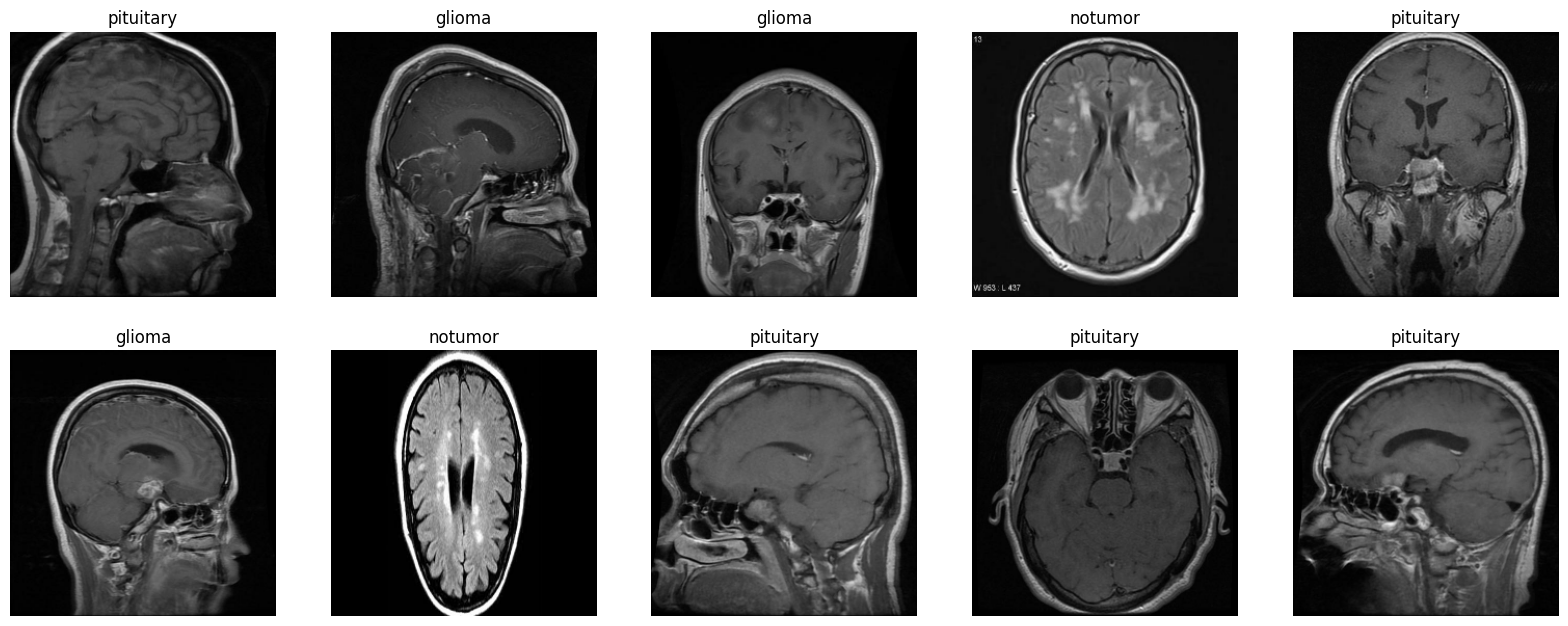

In [ ]:
plt.figure(figsize=(20,20))
for images, labels in train_ds.take(1):
  for i in range(10):
    ax = plt.subplot(5,5,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch,image_label in train_ds:
  print(image_batch.shape)
  print(image_label.shape)
  break

(128, 256, 256, 3)
(128,)


# Data Augmentation

In [ ]:

data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
])

# Normalizing Images

In [ ]:
normalizing_images = tf.keras.layers.Rescaling(1/255.)
normalized_dataset_train = train_ds.map(lambda x,y: (normalizing_images(x),y))
normalized_dataset_val = val_ds.map(lambda x,y: (normalizing_images(x),y))
normalized_dataset_test = test_ds.map(lambda x,y: (normalizing_images(x),y))

In [ ]:
images_batch,images_labels = next(iter(normalized_dataset_train))
first_image = image_batch[0]
print(np.min(first_image),np.max(first_image))

0.0 235.0


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
normalized_dataset_train = normalized_dataset_train.prefetch(buffer_size=AUTOTUNE)
normalized_dataset_val = normalized_dataset_val.prefetch(buffer_size=AUTOTUNE)
normalized_dataset_test = normalized_dataset_test.prefetch(buffer_size=AUTOTUNE)

In [ ]:
num_classes = len(class_names)
print(num_classes)

4


#Class Weights

In [ ]:
# Calculate class weights
labels = np.concatenate([y for x, y in train_ds], axis=0)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = dict(enumerate(class_weights))

# Convolution Model Architecture

In [ ]:
input_layer = Input(shape=(256, 256, 3))

conv1 = Conv2D(64, (3, 3), activation="relu", padding="same")(input_layer)
pool1 = MaxPool2D()(conv1)

conv2 = Conv2D(32, (3, 3), activation="relu")(pool1)
pool2 = MaxPool2D()(conv2)

conv3 = Conv2D(32, (3, 3), activation="relu")(pool2)
pool3 = MaxPool2D()(conv3)

conv4 = Conv2D(16, (3, 3), activation="relu")(pool3)

flat = Flatten()(conv4)
drop1 = Dropout(0.3)(flat)

dense1 = Dense(512, activation="relu")(drop1)
drop2 = Dropout(0.3)(dense1)

dense2 = Dense(256, activation="relu")(drop2)
dense3 = Dense(128, activation="relu")(dense2)

output_layer = Dense(120, activation="softmax")(dense3)

model = Model(inputs=input_layer, outputs=output_layer)

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 126, 126, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 61, 61, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │       6,423,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 120)                 │          15,480 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,636,872 (25.32 MB)

 Trainable params: 6,636,872 (25.32 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Number of epochs with no improvement after which training will stop
    restore_best_weights=True  # Restore the best weights when stopping
)
# Learning Rate Scheduler
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.2,         # Reduce learning rate by a factor of 0.2
    patience=3,         # Number of epochs with no improvement after which LR will be reduced
    min_lr=1e-6         # Minimum learning rate
)

In [ ]:
model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

In [ ]:
history = model.fit(normalized_dataset_train,
                    validation_data=normalized_dataset_val,
                    epochs=25,
                    class_weight=class_weights)

Epoch 1/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 33s 311ms/step - accuracy: 0.3277 - loss: 2.2194 - val_accuracy: 0.6156 - val_loss: 0.9893
Epoch 2/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.6959 - loss: 0.7636 - val_accuracy: 0.7618 - val_loss: 0.5936
Epoch 3/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.8145 - loss: 0.4906 - val_accuracy: 0.8301 - val_loss: 0.4615
Epoch 4/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.8580 - loss: 0.3874 - val_accuracy: 0.8039 - val_loss: 0.5164
Epoch 5/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.8527 - loss: 0.3994 - val_accuracy: 0.9011 - val_loss: 0.3174
Epoch 6/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.9231 - loss: 0.2261 - val_accuracy: 0.8713 - val_loss: 0.3394
Epoch 7/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.9296 - loss: 0.1929 - val_accuracy: 0.9440 - val_loss: 0.1833
Epoch 8/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.9630 - loss: 0.1100 - val_accuracy: 0.9571 -

In [ ]:
loss, acc = model.evaluate(normalized_dataset_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {acc}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9542 - loss: 0.3166
Test Loss: 0.33025193214416504
Test Accuracy: 0.9534706473350525


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


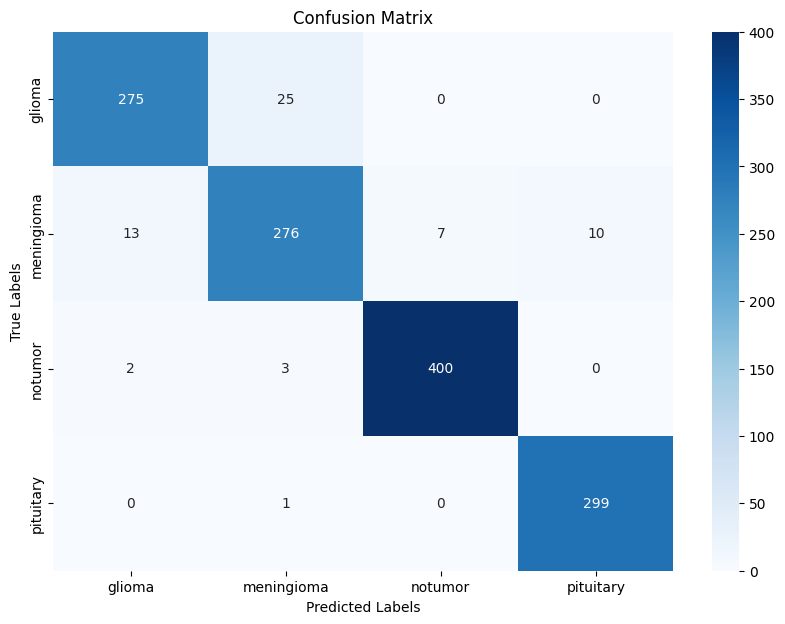

In [ ]:
all_predicted_labels = []
all_true_labels = []

for images_batch, labels_batch in normalized_dataset_test:
    # Make predictions on this batch and store them
    batch_predictions = model.predict(images_batch)
    batch_predicted_labels = np.argmax(batch_predictions, axis=1)
    all_predicted_labels.extend(batch_predicted_labels)

    # Store true labels of this batch
    all_true_labels.extend(labels_batch.numpy())

# Convert lists to numpy arrays
all_predicted_labels = np.array(all_predicted_labels)
all_true_labels = np.array(all_true_labels)

# Compute the confusion matrix
cm = confusion_matrix(all_true_labels, all_predicted_labels)

# Plot the confusion matrix with class labels
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Accuracy vs Validation Accuracy Graph

Text(0.5, 1.0, 'Training and Validation Accuracy')

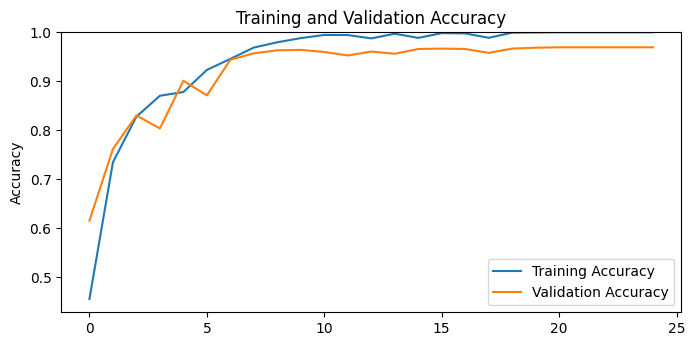

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

# Loss vs Validation Loss Graph

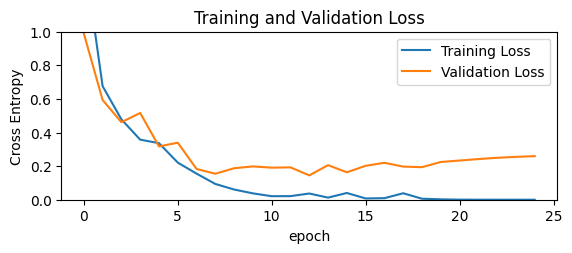

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Predicting Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
Predicted_label = pituitary and Actual Label = pituitary


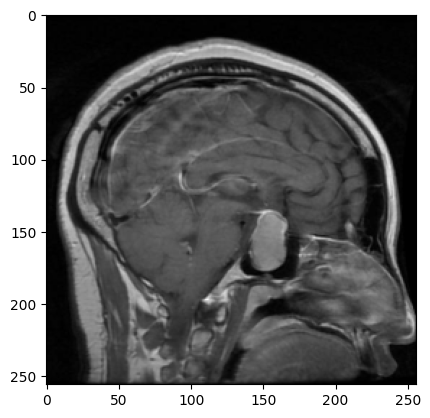

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted_label = pituitary and Actual Label = pituitary


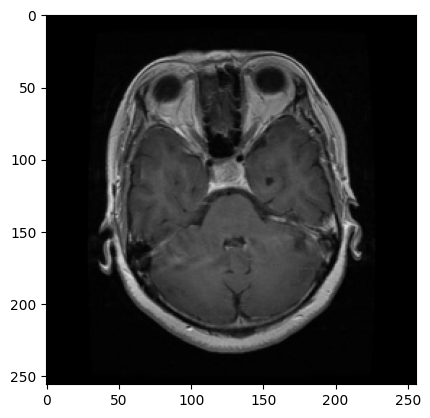

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted_label = meningioma and Actual Label = meningioma


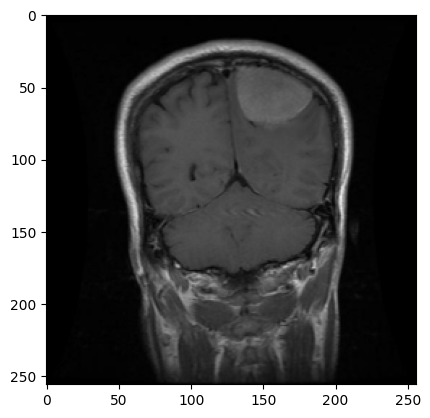

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted_label = meningioma and Actual Label = meningioma


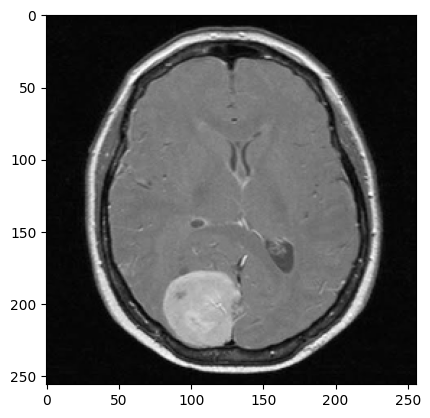

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted_label = notumor and Actual Label = notumor


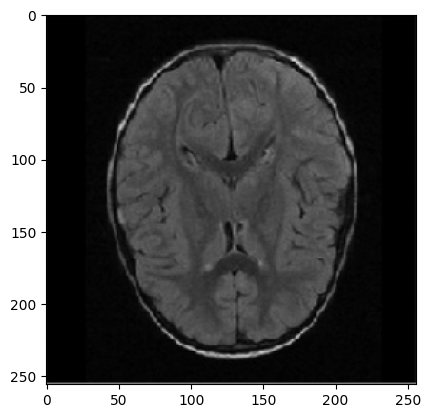

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted_label = pituitary and Actual Label = pituitary


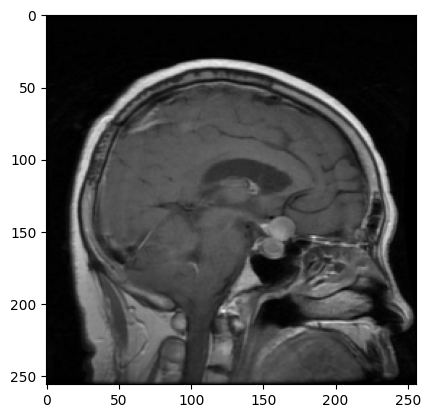

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted_label = meningioma and Actual Label = meningioma


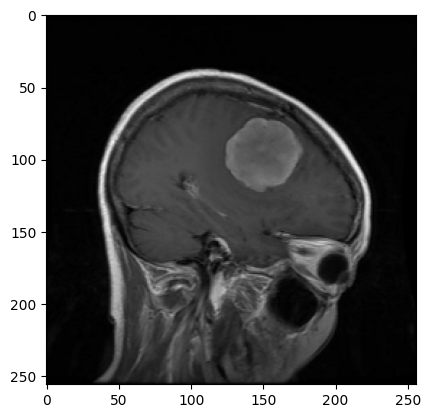

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted_label = pituitary and Actual Label = pituitary


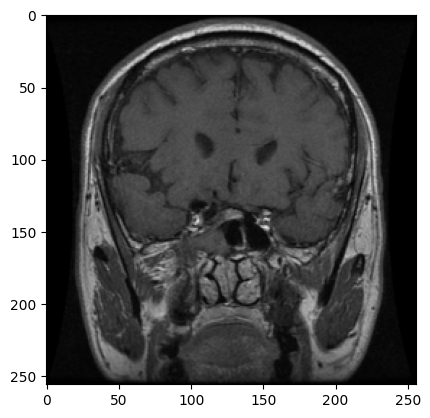

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted_label = pituitary and Actual Label = pituitary


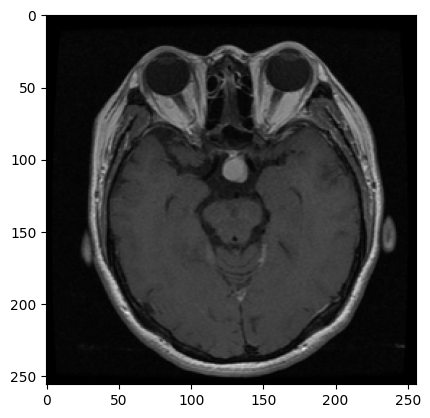

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted_label = notumor and Actual Label = notumor


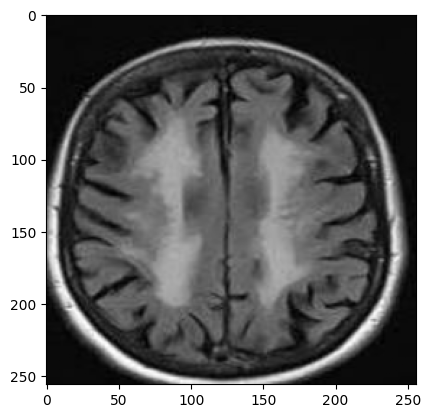

In [ ]:
images_test,labels_test = next(iter(normalized_dataset_test))
images_test[0].shape

for i in range(10):
    plt.imshow(images_test[i])
    prediction = np.argmax(model.predict(images_test[i][np.newaxis,...]))
    print(f"Predicted_label = {class_names[prediction]} and Actual Label = {class_names[labels_test[i]]}")
    plt.show()

# Saving the Model

In [ ]:
model.save("BrainTumorAIGood.keras")

from IPython.display import FileLink
FileLink(r"BrainTumorAIGood.keras")

/content/BrainTumorAIGood.keras

In [ ]:
from google.colab import files
files.download("BrainTumorAIGood.keras")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>